# (Practice) Transfer Learning

- For this assignment, you will apply one last approach to your Dangerous Farm Insects classification model (Source: Kaggle: https://www.kaggle.com/datasets/tarundalal/dangerous-insects-dataset)
- **Your goal is to apply Transfer Learning by using a Pre-trained model from Keras for feature extraction.**
- Use the augmentation to your model and compare it against your best model from the Tuning CNNs practice assignment.**

![img](https://assets.codingdojo.com/boomyeah2015/codingdojo/curriculum/content/chapter/1692317485__Screenshot20230817at81117PM.png)

## Getting Started

- Continue working in your repository from the previous practice assignment.
- Make a new notebook and copy the following from your previous assignments
    -  Your dataset preparation code.
    -  Your best model, whichever model it may be (it may not be the data augmentation model).

- FIt and evaluate the best model from your previous assignment.
    - This will be your baseline model to compare your transfer learning models against.


### Select & Download Pre-Trained Model

- Select at least 2 pre-trained models to try from the [Keras applications module](https://keras.io/api/applications/).
- Download only the base layers (use include_top=False)
    - Make sure to include the image size.
    - Set the base layers as trainable=False
- Create the Lambda preprocessing layer for the selected model.
- Build a neural network using the preprocessing layer and pre-trained convolutional base followed by:
    - A Flattening layer
    - A hidden Dense layer (optional)
    - A final output layer
- Fit and evaluate both of your transfer learning models (remember, you must select 2 pre-trained models to try).

## Save the Best Overall Model

- Choose 1 final model to save as your best model. It may not be your transfer learning model.
- Save the model as a .keras file so that you may revisit it to explain it with LIME.

# SOLUTION CODE

In [1]:
import numpy as np
import tensorflow as tf

# Set the seed for NumPy
np.random.seed(42)

# Set the seed for TensorFlow
tf.random.set_seed(42)

import os, glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
tf.__version__



'2.12.0'

In [2]:
# Define custom function
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [3]:
def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs

In [4]:
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

In [5]:
## PREVIOUS CLASSIFICATION_METRICS FUNCTION FROM INTRO TO ML
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")

    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

In [6]:
def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    
    return results_dict

### Create a Tensorflow Image Dataset

In [7]:
# Checking the contents of the folder (use your path)
data_dir = "Data/Dangerous Insects/farm_insects/"
data_dir

'Data/Dangerous Insects/farm_insects/'

In [8]:
# Getting list of img file paths 
img_files = glob.glob(data_dir+"**/*")
len(img_files)

1591

In [9]:
# Preview an example image (at full size)
img_loaded = load_img(img_files[0])
img_data = img_to_array(img_loaded)
img_data.shape

(650, 1160, 3)

In [10]:
# Saving image params as vars for reuse
batch_size = 32
img_height = 128
img_width = 128

In [11]:
# make the dataset from the main folder of images
ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    label_mode="categorical",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

ds

Found 1591 files belonging to 15 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

In [12]:
len(ds)

50

In [13]:
## Set the size of the 
split_train = 0.7
split_val = 0.20
split_test = 0.10 

# Calculate the number of batches for training and validation data 
n_train_batches =  int(len(ds) * split_train)
n_val_batches = int(len(ds) * split_val)

print(f"Use {n_train_batches} batches as training data")
print(f"Use {n_val_batches} batches as validation data")
print(f"The remaining {len(ds)- (n_train_batches+n_val_batches)} batches will be used as test data.")

Use 35 batches as training data
Use 10 batches as validation data
The remaining 5 batches will be used as test data.


In [14]:
# Use .take to slice out the number of batches 
train_ds = ds.take(n_train_batches)
len(train_ds)

35

In [15]:
## Create the val_ds from original ds

# 1. Skipping over the training batches
val_ds = ds.skip(n_train_batches)

# 2. Taking the correct number of validation batches
val_ds = val_ds.take(n_val_batches)
len(val_ds)

10

In [16]:
# Create the test split from ds

# SKip over all of the training + val images
test_ds = ds.skip(n_train_batches + n_val_batches)
len(test_ds)

5

In [17]:
# Determine number of batches in dataset
ds_size = len(ds)
ds_size

50

### Preview the Data

In [18]:
# checking the class names
class_names = ds.class_names

class_dict = dict(zip(range(len(class_names)), class_names))
class_dict

{0: 'Africanized Honey Bees (Killer Bees)',
 1: 'Aphids',
 2: 'Armyworms',
 3: 'Brown Marmorated Stink Bugs',
 4: 'Cabbage Loopers',
 5: 'Citrus Canker',
 6: 'Colorado Potato Beetles',
 7: 'Corn Borers',
 8: 'Corn Earworms',
 9: 'Fall Armyworms',
 10: 'Fruit Flies',
 11: 'Spider Mites',
 12: 'Thrips',
 13: 'Tomato Hornworms',
 14: 'Western Corn Rootworms'}

In [19]:
# Saving # of classes for reuse
num_classes = len(class_names)
num_classes

15

In [20]:
# Batch Size
batch_size

32

In [21]:
# taking a sample to see batch shape
example_batch_imgs,example_batch_y= train_ds.take(1).get_single_element()
example_batch_imgs.shape

TensorShape([32, 128, 128, 3])

In [22]:
# Individual image shape
input_shape = example_batch_imgs[0].shape
input_shape

TensorShape([128, 128, 3])

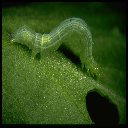

In [23]:
array_to_img(example_batch_imgs[0])

In [24]:
# Demo Unpacking shape
[*input_shape]

[128, 128, 3]

### Optimize Dataset Performance

In [25]:
# Use autotune to automatically determine best buffer sizes 
AUTOTUNE = tf.data.AUTOTUNE

# ORIGINAL SHUFFLED TRAIN
train_ds = train_ds.cache().shuffle(buffer_size= len(train_ds),
                                   seed=42).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model 1: Baseline Model

Note: Use your best performing model so far as your baseline for comparison.

In [26]:
def build_best_model():
    
    model = models.Sequential(name='TunedModel')
    # Using rescaling layer to scale pixel values
    model.add(layers.Rescaling(1./255, input_shape=input_shape))
    
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=32,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'))
    
    # Pooling layer
    pool_padding = 'same'
    pool_strides = 2
    model.add(layers.MaxPooling2D(pool_size=2, 
                                  padding=pool_padding,
                                 strides=pool_strides))  # Size of pooling


    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=32,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same')) 

    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2, 
                                  padding=pool_padding,
                                 strides=pool_strides))  # Size of pooling

    
    # Flattening layer
    model.add(layers.Flatten())

    # Adding a Hidden Dense Layer    
    model.add(layers.Dense(256, activation="relu") )

    model.add(layers.Dropout(.1))
    
    # Output layer
    model.add(
        layers.Dense(len(class_names), activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?
    
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

    
    model.summary()
    return model

Model: "TunedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32768)             0

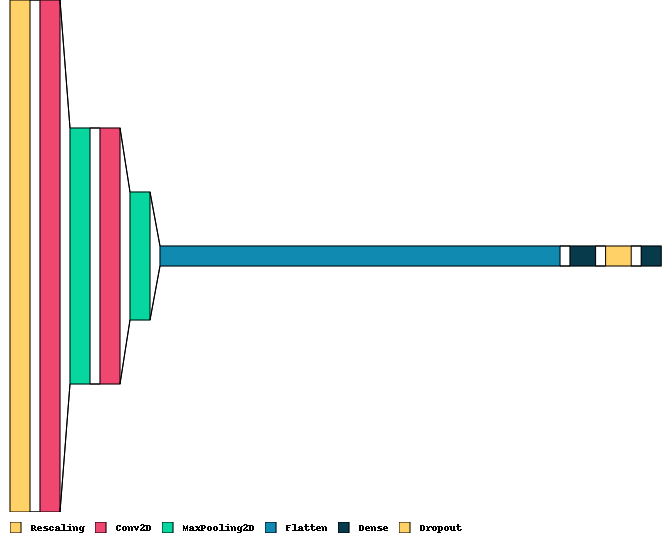

In [27]:
import visualkeras as vk
model1 = build_best_model()
vk.layered_view(model1, legend=True, 
                draw_volume=False, 
                to_file='practice_datasets_cnn.png')

In [28]:
def get_callbacks(monitor='val_accuracy', patience=5, restore_best_weights=False):
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience, 
                                                      restore_best_weights=restore_best_weights)
    return [early_stopping]

Model: "TunedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0

(<Figure size 600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'loss'}>,
        <Axes: title={'center': 'accuracy'}>], dtype=object))

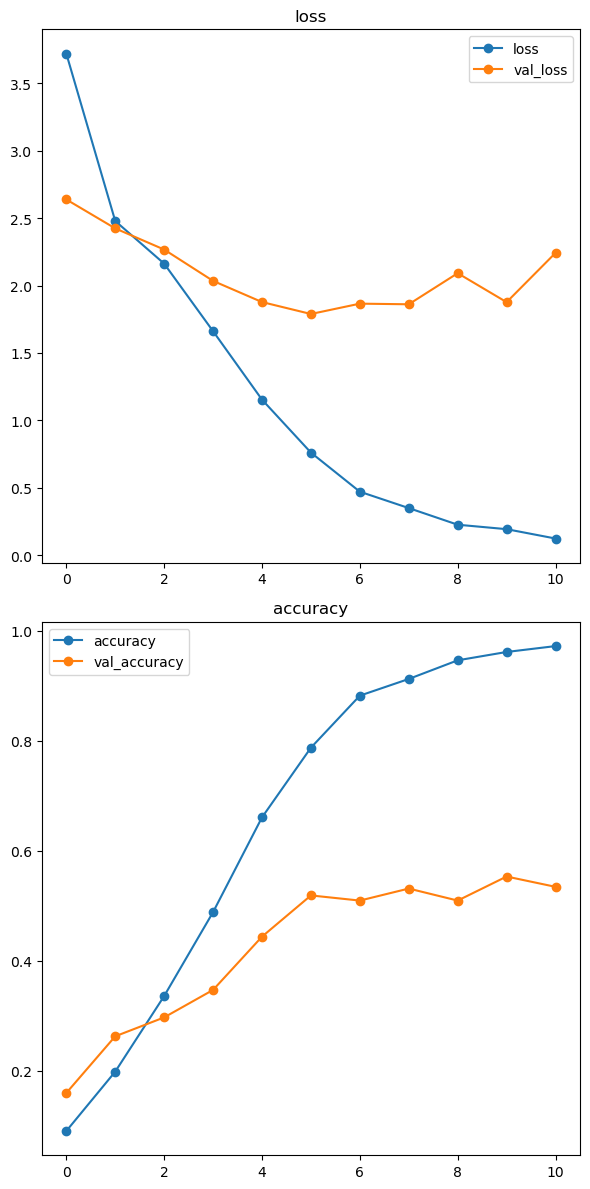

In [29]:
# Build fresh model and train
model1 = build_best_model()

# fit the neural network
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20, callbacks=get_callbacks())

plot_history(history)


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        69
           1       1.00      1.00      1.00        67
           2       0.75      0.99      0.85        73
           3       1.00      1.00      1.00        83
           4       1.00      1.00      1.00        65
           5       1.00      1.00      1.00        69
           6       1.00      1.00      1.00        80
           7       1.00      1.00      1.00        81
           8       1.00      1.00      1.00        78
           9       0.98      0.72      0.83        85
          10       1.00      1.00      1.00        72
          11       1.00      1.00      1.00        82
          12       0.99      1.00      0.99        75
          13       1.00      1.00    

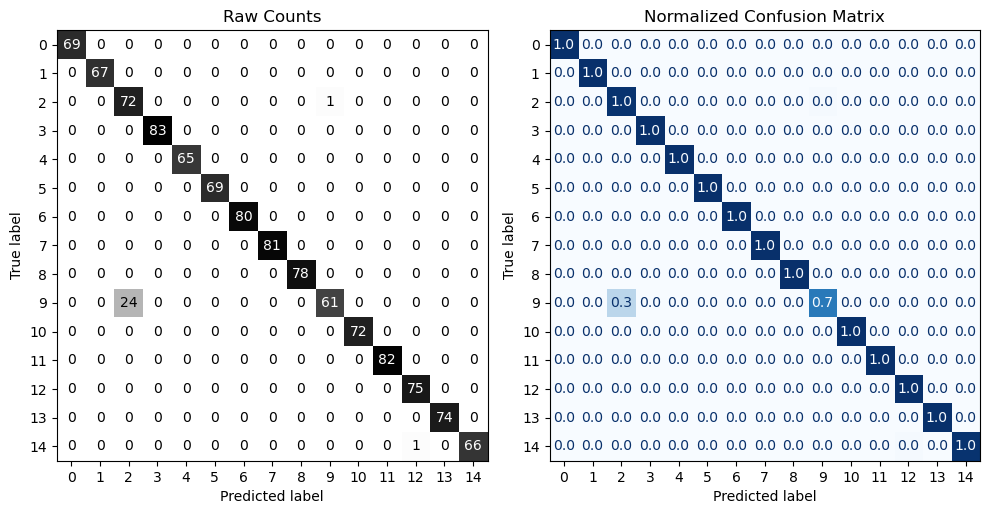


- Evaluating Training Data:
35/35 [==============================] - 2s 57ms/step - loss: 0.1040 - accuracy: 0.9768
{'loss': 0.10400887578725815, 'accuracy': 0.9767857193946838}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.40      0.22      0.29         9
           1       0.50      0.12      0.20         8
           2       0.14      0.50      0.22         8
           3       0.29      0.44      0.35         9
           4       0.70      0.64      0.67        11
           5       0.67      0.86      0.75        14
           6       0.75      0.55      0.63        11
           7       0.17      0.20      0.18         5
           8       0.73      0.57      0.64        14
           9       0.60      0.43      0.50         7
          10       0.75      0.33      0.46      

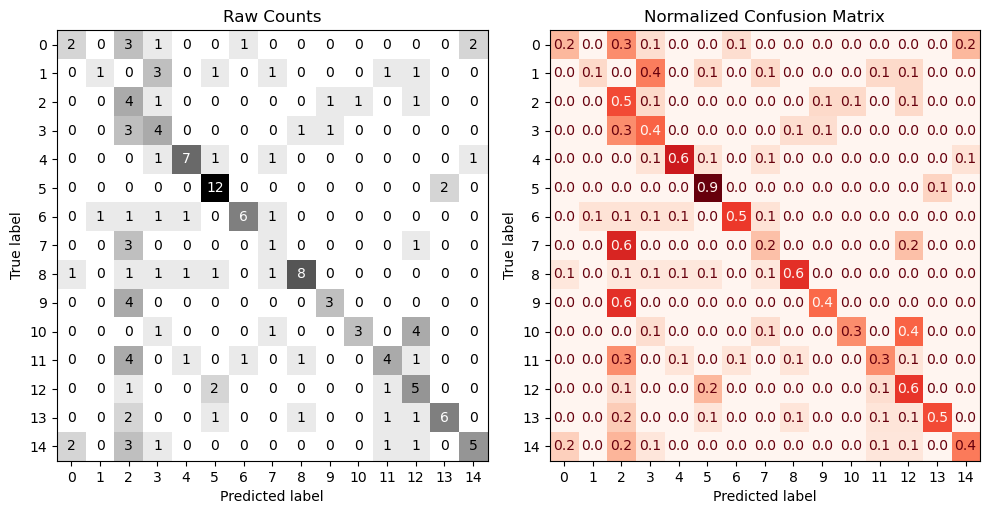


- Evaluating Test Data:
5/5 [==============================] - 0s 65ms/step - loss: 2.3767 - accuracy: 0.4702
{'loss': 2.3766655921936035, 'accuracy': 0.4701986610889435}


In [30]:
evaluate_classification_network(model1, X_train=train_ds, X_test=test_ds,
                                  figsize=(10,12), 
                                   values_format=".1f");

## Transfer Learning

### VGG16

In [31]:
# Download base
vgg16_base = tf.keras.applications.VGG16(include_top=False,
                                         weights='imagenet', 
                                        input_shape=input_shape
                                        )
# Prevent layers from base_model from changing 
vgg16_base.trainable = False

In [32]:
def build_transfer_model_vgg(pretrained_base,show_summary=True):
        
    model = models.Sequential()
    # Add input layer
    model.add( tf.keras.layers.Input(shape=input_shape))

    # Define lambda preprocessing layer
    lambda_layer = tf.keras.layers.Lambda(tf.keras.applications.vgg16.preprocess_input, 
                                      name='preprocess_input')
    # Addd lambda layer
    model.add(lambda_layer)
    
    # Add transfer learning model specified when function is called
    model.add(pretrained_base)
    
    # Flattening layer
    model.add(layers.Flatten())
    

    # Adding a Hidden Dense Layer    
    model.add(layers.Dense(256, activation="relu") )

    model.add(layers.Dropout(.1))
    
    # Output layer
    model.add(
        layers.Dense(len(class_names), activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?
    
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    if show_summary:
        model.summary()
    return model

In [33]:
# Run Build Function with pretrained model and processing layer
model = build_transfer_model_vgg(vgg16_base)

# fit and evaluate
history = model.fit(train_ds, validation_data=val_ds,epochs=25, 
                    callbacks=get_callbacks())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess_input (Lambda)   (None, 128, 128, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 15)                3855      
                                                                 
Total params: 16,815,951
Trainable params: 2,101,263
Non


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        69
           1       1.00      1.00      1.00        67
           2       0.87      0.93      0.90        73
           3       1.00      1.00      1.00        83
           4       0.98      1.00      0.99        65
           5       1.00      1.00      1.00        69
           6       1.00      1.00      1.00        80
           7       1.00      1.00      1.00        81
           8       1.00      1.00      1.00        78
           9       0.94      0.88      0.91        85
          10       1.00      1.00      1.00        72
          11       1.00      1.00      1.00        82
          12       1.00      1.00      1.00        75
          13       1.00      1.00    

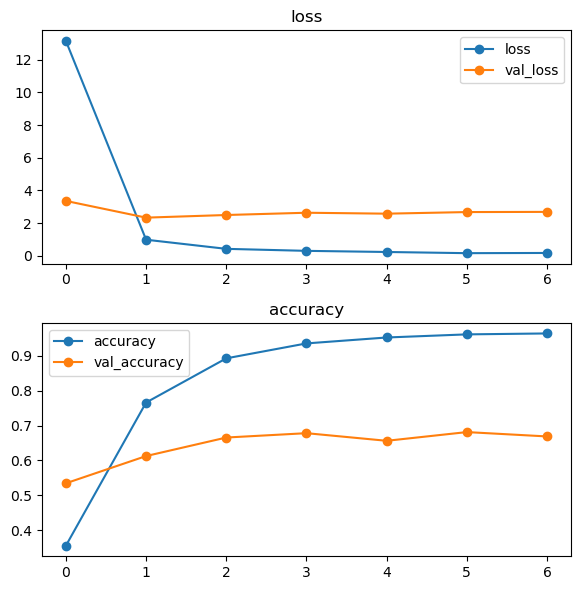

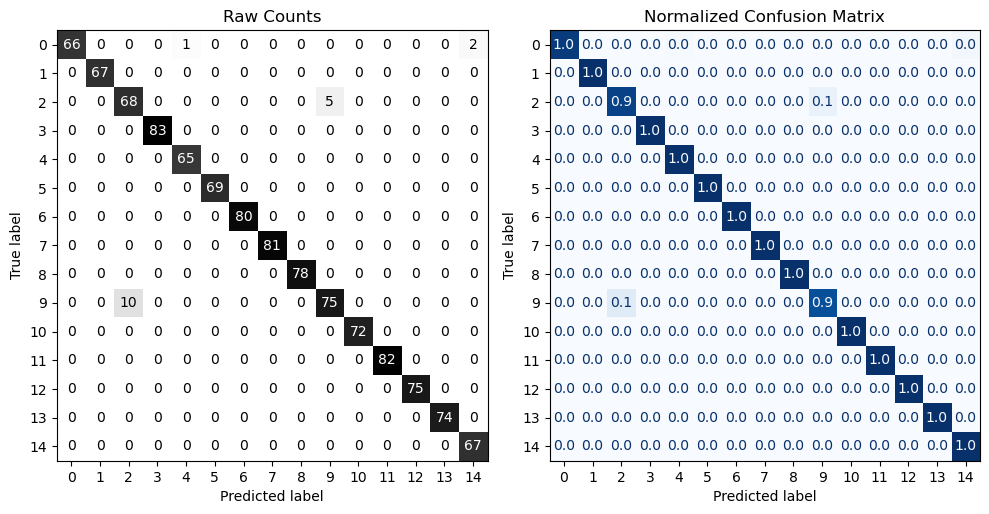


- Evaluating Training Data:
35/35 [==============================] - 55s 2s/step - loss: 0.0664 - accuracy: 0.9839
{'loss': 0.0663989782333374, 'accuracy': 0.9839285612106323}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.56      0.63         9
           1       0.33      0.25      0.29         8
           2       0.40      0.50      0.44         8
           3       0.60      0.67      0.63         9
           4       1.00      0.73      0.84        11
           5       0.87      0.93      0.90        14
           6       0.75      0.82      0.78        11
           7       0.20      0.20      0.20         5
           8       0.70      0.50      0.58        14
           9       0.38      0.43      0.40         7
          10       0.75      1.00      0.86        

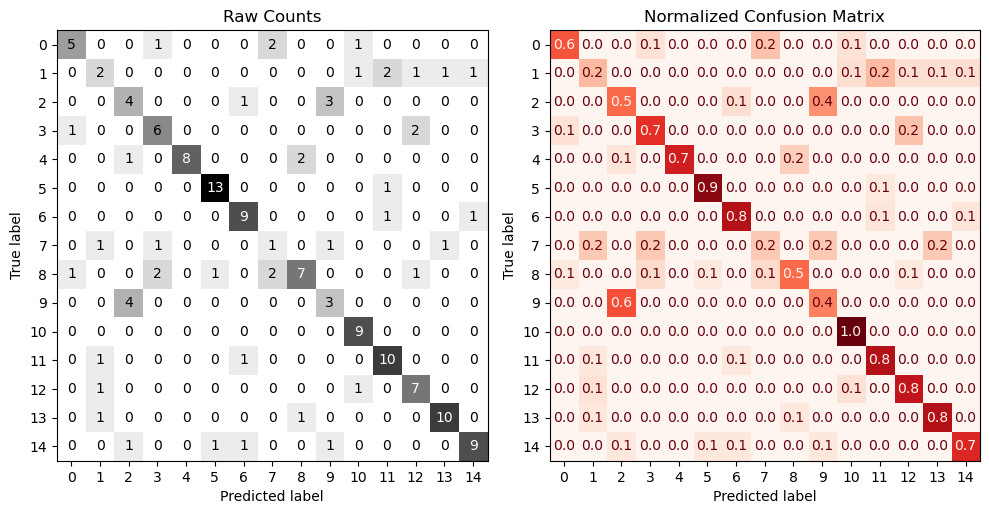


- Evaluating Test Data:
5/5 [==============================] - 7s 1s/step - loss: 2.9973 - accuracy: 0.6821
{'loss': 2.9973299503326416, 'accuracy': 0.6821191906929016}


In [34]:
evaluate_classification_network(model,X_train=train_ds,
                                   X_test=test_ds,history=history,
                                   figsize=(10,12), 
                                   values_format=".1f");

### EfficientNet

In [35]:
# Download base
efficientnet_base =tf.keras.applications.EfficientNetB0(include_top=False, 
                                                       input_shape=input_shape)

# prevent training of transfer model
efficientnet_base.trainable = False

In [36]:
def build_transfer_model_effnet(pretrained_base, show_summary=True):
    model = models.Sequential()

    # Add input layer
    model.add( tf.keras.layers.Input(shape=input_shape))

    # Define lambda preprocessing layer
    lambda_layer = tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input, 
                                      name='preprocess_input_enet')
    # Add lambda layer to model
    model.add(lambda_layer)
    
    # Add transfer learning model defined when function is called 
    model.add(pretrained_base)
    
    # Flattening layer
    model.add(layers.Flatten())
    

    # Adding a Hidden Dense Layer    
    model.add(layers.Dense(256, activation="relu") )

    model.add(layers.Dropout(.1))
    
    # Output layer
    model.add(
        layers.Dense(len(class_names), activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?
    
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    if show_summary:
        model.summary()
    return model

In [37]:
# build model with efficentnet base
model_effnet = build_transfer_model_effnet(efficientnet_base)

history = model_effnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=get_callbacks()  
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess_input_enet (Lamb  (None, 128, 128, 3)      0         
 da)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 flatten_3 (Flatten)         (None, 20480)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               5243136   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 15)                3855      
                                                      


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        69
           1       1.00      1.00      1.00        67
           2       0.87      0.93      0.90        73
           3       1.00      1.00      1.00        83
           4       0.98      1.00      0.99        65
           5       1.00      1.00      1.00        69
           6       1.00      1.00      1.00        80
           7       1.00      1.00      1.00        81
           8       1.00      1.00      1.00        78
           9       0.94      0.88      0.91        85
          10       1.00      1.00      1.00        72
          11       1.00      1.00      1.00        82
          12       1.00      1.00      1.00        75
          13       1.00      1.00    

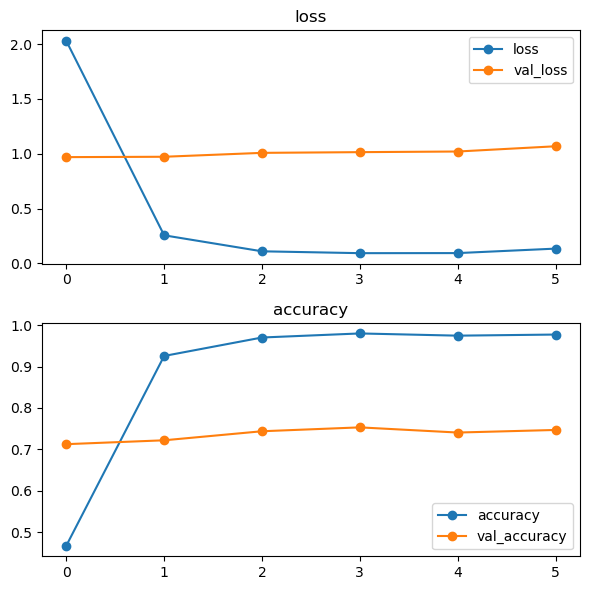

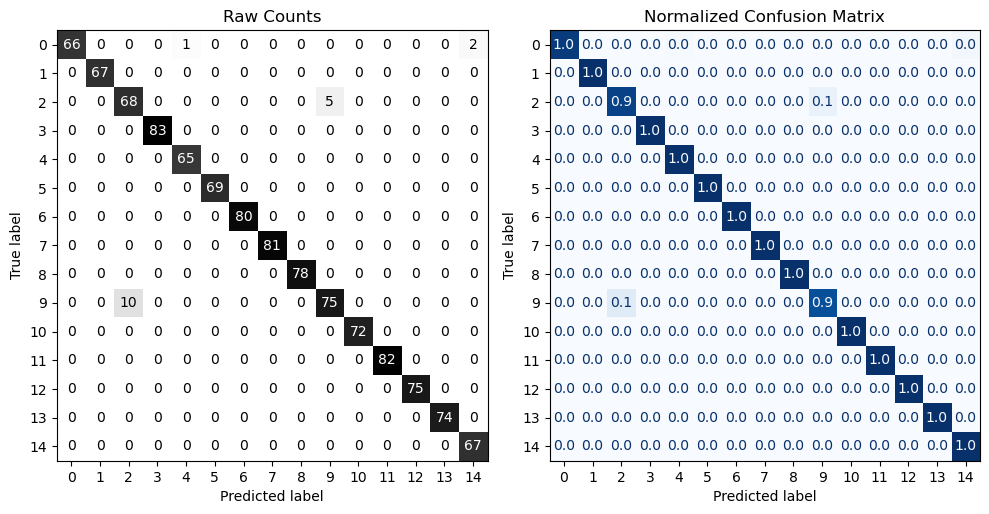


- Evaluating Training Data:
35/35 [==============================] - 60s 2s/step - loss: 0.0664 - accuracy: 0.9839
{'loss': 0.0663989782333374, 'accuracy': 0.9839285612106323}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.56      0.63         9
           1       0.33      0.25      0.29         8
           2       0.40      0.50      0.44         8
           3       0.60      0.67      0.63         9
           4       1.00      0.73      0.84        11
           5       0.87      0.93      0.90        14
           6       0.75      0.82      0.78        11
           7       0.20      0.20      0.20         5
           8       0.70      0.50      0.58        14
           9       0.38      0.43      0.40         7
          10       0.75      1.00      0.86        

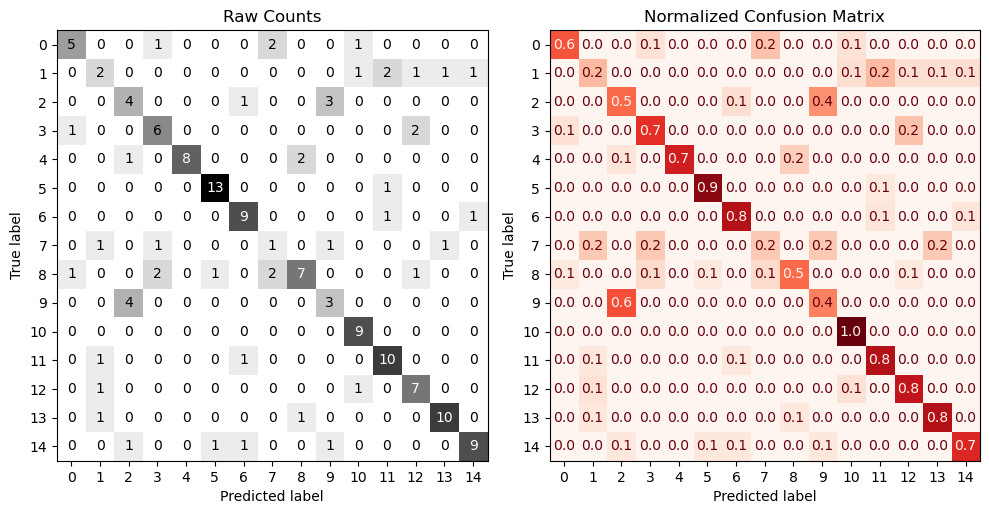


- Evaluating Test Data:
5/5 [==============================] - 8s 2s/step - loss: 2.9973 - accuracy: 0.6821
{'loss': 2.9973299503326416, 'accuracy': 0.6821191906929016}


In [38]:
evaluate_classification_network(
    model, X_train=train_ds, X_test=test_ds, history=history,
    figsize=(10,12), 
                                   values_format=".1f");

## Optional KerasTuner
You can continue to tune your model.
(This particular tuner will take HOURS to run.)

In [39]:
import keras_tuner as kt
import os

## Import HyperParameters for help preparing code
from keras_tuner import HyperParameters as hp

In [40]:
# Create a folder for training logs
folder = 'KerasTuner/'
os.makedirs(folder, exist_ok=True)

In [41]:
# # Downloading just the convolutional base
# vgg16_base = tf.keras.applications.VGG16(
#     include_top=False, weights="imagenet", input_shape=input_shape
# )
# # Prevent layers from base_model from changing 
# vgg16_base.trainable = False


def tune_vgg16_model(hp):
    model = models.Sequential(name="VGG16")
    # Add input layer
    model.add(tf.keras.layers.Input(shape=input_shape))

    # Define lambda preprocessing layer
    lambda_layer = tf.keras.layers.Lambda(tf.keras.applications.vgg16.preprocess_input, 
                                      name='preprocess_input')
   
    # Adding preprocessing lambda layer
    model.add(lambda_layer)

    # Add pretrained base
    model.add(vgg16_base)

    # Flattening layer
    model.add(layers.Flatten())

    ## Adding a Hidden Dense Layer
    model.add(layers.Dense(hp.Int("n_units",
                                  min_value=256, 
                                  max_value=2056,
                                  step=256),
                           activation="relu"))
    model.add(layers.Dropout(hp.Float("dropout_rate",
                                      min_value=0.2, 
                                      max_value=0.6,
                                      step = .2)))

    # Output layer
    model.add(layers.Dense(len(class_names), activation="softmax"))

    lr = hp.Float('learning_rate',min_value=.0001, max_value=10, step=10, sampling='log')
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    model.summary()
    return model

In [42]:
#hyperband allows for callbacks
tuner_hb = kt.Hyperband(tune_vgg16_model, objective='val_accuracy',
                        max_epochs=15, overwrite=True, directory=folder, 
                project_name='tuning-vgg16',)
tuner_hb.search_space_summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess_input (Lambda)   (None, 128, 128, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 15)                3855      
                                                                 
Total params: 16,815,951
Trainable params: 2,101,263
Non-trai

In [43]:
tuner_hb.search(train_ds,validation_data=val_ds, epochs=20, callbacks=get_callbacks())
tuner_hb.results_summary()

Trial 30 Complete [00h 15m 34s]
val_accuracy: 0.671875

Best val_accuracy So Far: 0.703125
Total elapsed time: 03h 06m 16s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in KerasTuner/tuning-vgg16
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0012 summary
Hyperparameters:
n_units: 1024
dropout_rate: 0.4
learning_rate: 0.001
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0011
Score: 0.703125

Trial 0027 summary
Hyperparameters:
n_units: 1280
dropout_rate: 0.4
learning_rate: 0.0001
tuner/epochs: 15
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.703125

Trial 0016 summary
Hyperparameters:
n_units: 1024
dropout_rate: 0.4
learning_rate: 0.001
tuner/epochs: 15
tuner/initial_epoch: 5
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.6968749761581421

Trial 0024 summary
Hyperparameters:
n_units: 1792
dropout_rate: 0.4
learning_rate: 0.0001
tuner/epochs: 15
tuner/initial_epoch: 5


In [44]:
best_hps = tuner_hb.get_best_hyperparameters()[0]
print(best_hps.values)

{'n_units': 1024, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'tuner/epochs': 5, 'tuner/initial_epoch': 2, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0011'}


In [45]:
best_model = tuner_hb.get_best_models()[0]
best_model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess_input (Lambda)   (None, 128, 128, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1024)              8389632   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 15)                15375     
                                                                 
Total params: 23,119,695
Trainable params: 8,405,007
Non-trai


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        69
           1       1.00      1.00      1.00        67
           2       0.81      0.90      0.86        73
           3       1.00      1.00      1.00        83
           4       1.00      1.00      1.00        65
           5       0.99      1.00      0.99        69
           6       1.00      1.00      1.00        80
           7       0.98      0.98      0.98        81
           8       0.96      0.97      0.97        78
           9       0.91      0.82      0.86        85
          10       1.00      0.99      0.99        72
          11       1.00      0.99      0.99        82
          12       0.99      1.00      0.99        75
          13       1.00      1.00    

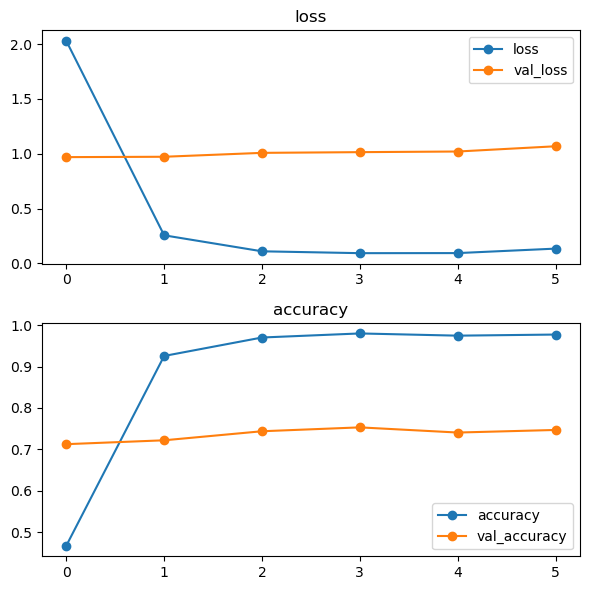

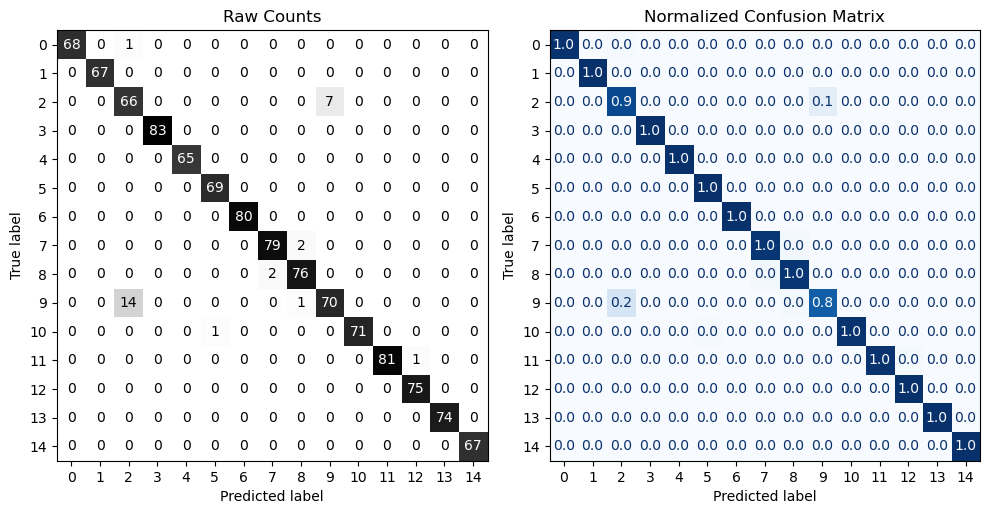


- Evaluating Training Data:
35/35 [==============================] - 59s 2s/step - loss: 0.3757 - accuracy: 0.9741
{'loss': 0.37566590309143066, 'accuracy': 0.9741071462631226}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.40      0.50      0.44         8
           2       0.31      0.62      0.42         8
           3       0.78      0.78      0.78         9
           4       0.89      0.73      0.80        11
           5       0.80      0.86      0.83        14
           6       1.00      0.82      0.90        11
           7       0.40      0.40      0.40         5
           8       0.92      0.79      0.85        14
           9       0.75      0.43      0.55         7
          10       0.89      0.89      0.89       

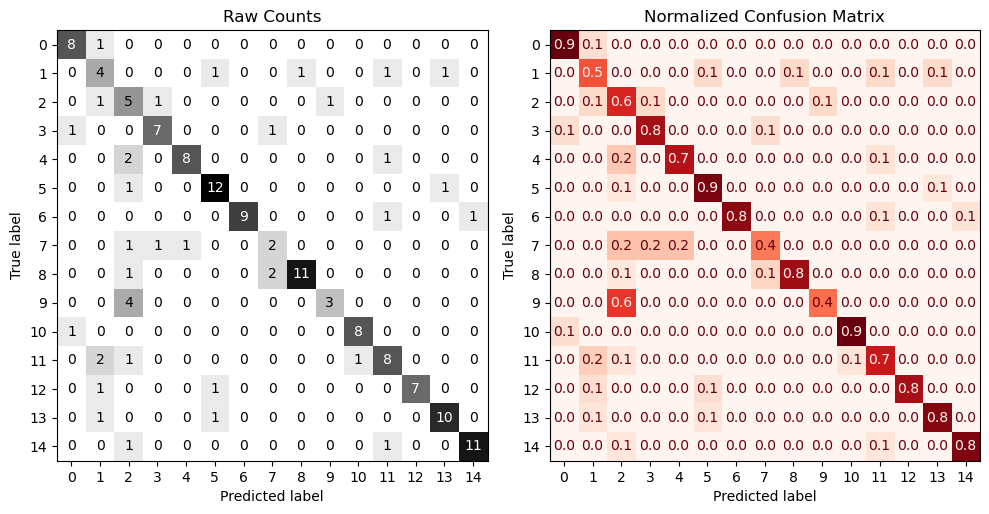


- Evaluating Test Data:
5/5 [==============================] - 7s 1s/step - loss: 4.2648 - accuracy: 0.7483
{'loss': 4.264824390411377, 'accuracy': 0.748344361782074}


In [46]:
evaluate_classification_network(
    best_model,
    X_train=train_ds,
    X_test=test_ds,
    history=history,
    figsize=(10, 12),
    values_format=".1f",
);

In [47]:
# saving the best model with optimizer
model_fname = 'BestModels/transfer-learning-insects-acc75.keras'
best_model.save(model_fname)#,include_optimizer=False)

In [48]:
# saving the best model without optimizer
model_fname = 'BestModels/transfer-learning-insects-acc75-no-opt.keras'
best_model.save(model_fname,include_optimizer=False)